# Set Environment

In [ ]:
!pip install category_encoders

In [ ]:
# Import libraries
import os
import re
from datetime import timedelta
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from IPython.display import display, HTML, Image

import pandas_gbq

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import RandomOverSampler
import category_encoders as ce
%matplotlib inline

plt.style.use('ggplot')
# plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [ ]:
# authenticate
auth.authenticate_user()

In [ ]:
# Set up environment variables
project_id = 'model-wave-394405'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pandas_gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# set the dataset
# if you want to use the demo, change this to mimic_demo
dataset = 'mimiciv'

# Feature Selection

## Select stroke patients

In [ ]:
select_stroke_query = f"""
SELECT *
FROM `physionet-data.mimiciv_hosp.diagnoses_icd`
WHERE icd_code LIKE 'I61%' OR icd_code LIKE 'I63%';
"""
stroke_df = run_query(select_stroke_query)
stroke_subject_ids = stroke_df['subject_id'].unique().tolist()
stroke_hadm_ids = stroke_df['hadm_id'].unique().tolist()

Downloading: 100%|██████████|


## Demographics

### admittime, dischtime, deathtime, insurance, martial status, race

In [ ]:
select_demographics_query_in_admission = f"""
SELECT subject_id, hadm_id, admittime, dischtime, deathtime, insurance, marital_status, race
FROM `physionet-data.mimiciv_hosp.admissions`
WHERE subject_id IN ({', '.join(map(str, stroke_subject_ids))})
AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))});
"""
demographics_df = run_query(select_demographics_query_in_admission)
demographics_df

Downloading: 100%|██████████|


,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND
...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE


### gender, age

In [ ]:
select_gender_and_age_query = f"""
SELECT subject_id,gender, anchor_age
FROM `physionet-data.mimiciv_hosp.patients`
WHERE subject_id IN ({', '.join(map(str, stroke_subject_ids))});
"""
gender_and_df = run_query(select_gender_and_age_query)
demographics_df = demographics_df.merge(gender_and_df, on=['subject_id'], how='inner')
demographics_df

Downloading: 100%|██████████|


,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52
...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62


### weight

In [ ]:
# 226512 Admission weight
select_weight_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) as weight
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 226512 AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;
"""
weight_df = run_query(select_weight_query)
weight_df

Downloading: 100%|██████████|


,subject_id,hadm_id,weight
0,11397887,22891945,62.4
1,17582515,24819548,86.3
2,16442940,23226100,117.0
3,18769342,29336424,74.2
4,16328106,26462581,82.4
...,...,...,...
2412,14022789,21024796,72.1
2413,19755487,25879196,64.6
2414,18777918,24753501,69.3
2415,11616349,27813437,69.0


In [ ]:
demographics_df = demographics_df.merge(weight_df, on=['subject_id','hadm_id'], how='left')
demographics_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0


## Vital signs

In [ ]:
# 220045  heart rate
# 220210  Respiratory Rate
# 220050  Arterial Blood Pressure systolic
# 220051  Arterial Blood Pressure diastolic
# 220052  Arterial Blood Pressure mean
# 228232  PAR-Oxygen saturation

select_vital_signs_query = f"""
SELECT *
FROM `physionet-data.mimiciv_icu.d_items`
WHERE itemid IN (220045, 220210, 220050, 220051, 220052, 228232);
"""
vital_signs_query = run_query(select_vital_signs_query)
vital_signs_query


Downloading: 100%|██████████|


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220210,Respiratory Rate,RR,chartevents,Respiratory,insp/min,Numeric,NaN,NaN
1,228232,PAR-Oxygen saturation,PAR-Oxygen saturation,chartevents,Routine Vital Signs,None,Text,NaN,NaN
2,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
3,220050,Arterial Blood Pressure systolic,ABPs,chartevents,Routine Vital Signs,mmHg,Numeric,90.0,140.0
4,220051,Arterial Blood Pressure diastolic,ABPd,chartevents,Routine Vital Signs,mmHg,Numeric,60.0,90.0
5,220052,Arterial Blood Pressure mean,ABPm,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN


### Heart Rate

In [ ]:
select_hr_query = f"""
SELECT subject_id, hadm_id, AVG(hr_value) AS hr_value
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS hr_value
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 220045
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
hr_df = run_query(select_hr_query)
hr_df

Downloading: 100%|██████████|


,subject_id,hadm_id,hr_value
0,17036732,26563830,81.448276
1,15488719,28134441,53.000000
2,16331109,23234327,83.363636
3,14331151,24487999,88.781250
4,14732303,27965592,81.115385
...,...,...,...
2415,13102372,23983646,82.350000
2416,19940947,28526241,64.000000
2417,15847847,21271626,72.625000
2418,12913705,29148179,61.500000


In [ ]:
demographics_vitial_signs_df = demographics_df.merge(hr_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,69.052632
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,127.480000
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,85.208333
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,80.800000
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.097826


### Respiratory Rate

In [ ]:
select_rr_query = f"""
SELECT subject_id, hadm_id, AVG(rr_value) AS rr_value
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS rr_value
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 220210
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
rr_df = run_query(select_rr_query)
rr_df

Downloading: 100%|██████████|


,subject_id,hadm_id,rr_value
0,10215159,24039782,26.995434
1,11425757,24642620,21.268456
2,16825279,23283649,21.977330
3,18843829,25308148,20.038462
4,15857793,21064907,22.329293
...,...,...,...
2409,19524347,26369278,19.518519
2410,10635441,27536393,14.000000
2411,10828036,22663235,23.160000
2412,10514013,29639378,16.142857


In [ ]:
demographics_vitial_signs_df = demographics_vitial_signs_df.merge(rr_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,69.052632,16.025000
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,127.480000,26.714286
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,85.208333,15.458333
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,80.800000,18.320000
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.097826,19.315217


### SPO2

In [ ]:
select_SPO2_query = f"""
SELECT subject_id, hadm_id, AVG(SPO2_value) AS SPO2_value
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS SPO2_value
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 228232
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
SPO2_df = run_query(select_SPO2_query)
SPO2_df

Downloading: 100%|██████████|


,subject_id,hadm_id,SPO2_value
0,17605210,22849785,2.00
1,16646033,27497381,1.00
2,16949150,22630344,2.00
3,16816038,26562570,0.00
4,16293620,24841345,2.00
...,...,...,...
117,17048763,25601605,1.00
118,15031111,27917559,1.25
119,11211333,26923258,1.00
120,12790735,27667946,2.00


In [ ]:
demographics_vitial_signs_df = demographics_vitial_signs_df.merge(SPO2_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,69.052632,16.025000,NaN
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,127.480000,26.714286,NaN
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,85.208333,15.458333,NaN
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,80.800000,18.320000,NaN
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.097826,19.315217,NaN


### Arterial Blood Pressure systolic

In [ ]:
select_BPS_query = f"""
SELECT subject_id, hadm_id, AVG(BPS_value) AS BPS_value
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS BPS_value
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 220050
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""

BPS_df = run_query(select_BPS_query)
BPS_df

Downloading: 100%|██████████|


,subject_id,hadm_id,BPS_value
0,12543250,20141818,116.272727
1,19717191,24315044,97.093023
2,18911483,27165016,124.680851
3,18635171,28967101,148.578947
4,16432173,22847120,117.285714
...,...,...,...
634,13013759,26057151,143.812500
635,12307948,21770096,174.692308
636,16818384,22438990,127.750000
637,15694807,23689324,165.000000


In [ ]:
demographics_vitial_signs_df = demographics_vitial_signs_df.merge(BPS_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,69.052632,16.025000,NaN,NaN
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,127.480000,26.714286,NaN,105.0
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,85.208333,15.458333,NaN,NaN
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,80.800000,18.320000,NaN,NaN
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.097826,19.315217,NaN,NaN


### Arterial Blood Pressure diastolic

In [ ]:
select_BPD_query = f"""
SELECT subject_id, hadm_id, AVG(BPD_value) AS BPD_value
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS BPD_value
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 220051
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
BPD_df = run_query(select_BPD_query)
BPD_df

Downloading: 100%|██████████|


,subject_id,hadm_id,BPD_value
0,13306976,26209285,48.750000
1,19290303,25206654,48.282828
2,16268687,23438193,53.758621
3,19678538,28383469,63.142857
4,17196501,27250817,60.818182
...,...,...,...
634,13262317,28797991,59.500000
635,16835786,29341398,72.461538
636,17719188,25006664,53.500000
637,11953908,21366986,41.600000


In [ ]:
demographics_vitial_signs_df = demographics_vitial_signs_df.merge(BPD_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,BPD_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,69.052632,16.025000,NaN,NaN,NaN
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,127.480000,26.714286,NaN,105.0,54.5
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,85.208333,15.458333,NaN,NaN,NaN
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,80.800000,18.320000,NaN,NaN,NaN
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.097826,19.315217,NaN,NaN,NaN


### Arterial Blood Pressure Mean

In [ ]:
select_BPM_query = f"""
SELECT subject_id, hadm_id, AVG(BPM_value) AS BPM_value
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS BPM_value
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 220052
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
BPM_df = run_query(select_BPM_query)
BPM_df

Downloading: 100%|██████████|


,subject_id,hadm_id,BPM_value
0,19874175,24919300,87.192308
1,13419296,27921658,89.518519
2,10955612,29972674,77.708333
3,10067389,23577021,91.322581
4,15612258,26723182,98.454545
...,...,...,...
637,14755254,28933877,77.647059
638,13205038,24285099,87.814815
639,17009119,22283459,85.000000
640,18749464,25359386,57.333333


In [ ]:
demographics_vitial_signs_df = demographics_vitial_signs_df.merge(BPM_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,69.052632,16.025000,NaN,NaN,NaN,NaN
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,127.480000,26.714286,NaN,105.0,54.5,69.0
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,85.208333,15.458333,NaN,NaN,NaN,NaN
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,80.800000,18.320000,NaN,NaN,NaN,NaN
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.097826,19.315217,NaN,NaN,NaN,NaN


## Laboratory results

In [ ]:
# Anion Gap 227073
# Chloride (serum)	220602

select_laboratory_results_query = f"""
SELECT *
FROM `physionet-data.mimiciv_icu.d_items`
WHERE LOWER(label) like '%chloride%'
"""
laboratory_results_query = run_query(select_laboratory_results_query)
laboratory_results_query

Downloading: 100%|██████████|


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220602,Chloride (serum),Chloride (serum),chartevents,Labs,None,Numeric,NaN,NaN
1,226536,Chloride (whole blood),Chloride (whole blood),chartevents,Labs,None,Numeric,NaN,NaN
2,228385,Chloride (serum) (soft),Chloride (serum) (soft),chartevents,Labs,None,Numeric with tag,NaN,NaN
3,228386,Chloride (whole blood) (soft),Chloride (whole blood) (soft),chartevents,Labs,None,Numeric with tag,NaN,NaN
4,225166,Potassium Chloride,Potassium Chloride - KCL,inputevents,Medications,mEq,Solution,NaN,NaN
5,227520,Methadone Hydrochloride,Methadone Hydrochloride,inputevents,Medications,mg,Solution,NaN,NaN
6,229618,Calcium Chloride,Calcium Chloride,inputevents,Medications,mg,Solution,NaN,NaN
7,220367,Chloride (ingr),Cl (ingr),ingredientevents,Ingredients - general (Not In Use),mg,Ingredient,NaN,NaN


### Anion Gap

In [ ]:
select_AG_query = f"""
SELECT subject_id, hadm_id, AVG(AG_value) AS AG_value
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS AG_value
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 227073
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
AG_df = run_query(select_AG_query)
AG_df

Downloading: 100%|██████████|


,subject_id,hadm_id,AG_value
0,19122448,24507586,10.583333
1,12818797,27446894,16.000000
2,16171489,23282358,21.333333
3,13352372,28752421,19.020408
4,18677117,23045104,12.000000
...,...,...,...
2277,14395135,20335895,17.000000
2278,11601244,25992205,15.000000
2279,16913836,25000857,16.000000
2280,14410396,29299054,17.000000


In [ ]:
demo_vs_lab_df = demographics_vitial_signs_df.merge(AG_df, on=['subject_id','hadm_id'], how='left')
demo_vs_lab_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value,AG_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,69.052632,16.025000,NaN,NaN,NaN,NaN,17.00
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,127.480000,26.714286,NaN,105.0,54.5,69.0,12.00
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,85.208333,15.458333,NaN,NaN,NaN,NaN,16.50
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,80.800000,18.320000,NaN,NaN,NaN,NaN,15.00
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.097826,19.315217,NaN,NaN,NaN,NaN,14.75


### Chloride (serum)

In [ ]:
select_chloride_query = f"""
SELECT subject_id, hadm_id, AVG(chloride_value) AS chloride_value
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS chloride_value
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 220602
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
chloride_df = run_query(select_chloride_query)
chloride_df

Downloading: 100%|██████████|


,subject_id,hadm_id,chloride_value
0,16963541,25415666,115.250000
1,16583373,27088456,102.636364
2,18367110,24602327,97.333333
3,15474523,20266641,103.272727
4,14299609,28444007,103.333333
...,...,...,...
2277,15452249,26082278,108.000000
2278,11085838,26061438,114.000000
2279,18754526,29881870,100.000000
2280,15924055,21730120,100.000000


In [ ]:
demo_vs_lab_df = demo_vs_lab_df.merge(chloride_df, on=['subject_id','hadm_id'], how='left')
demo_vs_lab_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value,AG_value,chloride_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,69.052632,16.025000,NaN,NaN,NaN,NaN,17.00,98.00
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,127.480000,26.714286,NaN,105.0,54.5,69.0,12.00,107.00
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,85.208333,15.458333,NaN,NaN,NaN,NaN,16.50,100.25
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,80.800000,18.320000,NaN,NaN,NaN,NaN,15.00,86.50
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.097826,19.315217,NaN,NaN,NaN,NaN,14.75,93.75


### Bicarbonate

In [ ]:
# Red Blood Cells counts 51279
# White Blood Cells 51301
# Bicarbonate 50882

select_bicarbonate_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) AS bicarbonate_value
FROM `physionet-data.mimiciv_hosp.labevents`
WHERE itemid = 50882 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
group by subject_id, hadm_id;
"""
bicarbonate_df = run_query(select_bicarbonate_query)
bicarbonate_df


Downloading: 100%|██████████|


,subject_id,hadm_id,bicarbonate_value
0,10122772,23565074,23.954545
1,10387412,28763199,24.500000
2,10445331,24253259,25.956522
3,10475473,21126571,22.277778
4,10501909,28905562,25.250000
...,...,...,...
3823,12290932,21224151,24.000000
3824,17354158,27249053,26.000000
3825,18270948,26240787,24.000000
3826,10690270,28376369,28.000000


In [ ]:
demo_vs_lab_df = demo_vs_lab_df.merge(bicarbonate_df, on=['subject_id','hadm_id'], how='left')
demo_vs_lab_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value,AG_value,chloride_value,bicarbonate_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,69.052632,16.025000,NaN,NaN,NaN,NaN,17.00,98.00,25.428571
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,127.480000,26.714286,NaN,105.0,54.5,69.0,12.00,107.00,25.333333
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,85.208333,15.458333,NaN,NaN,NaN,NaN,16.50,100.25,20.200000
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.600000
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,80.800000,18.320000,NaN,NaN,NaN,NaN,15.00,86.50,39.400000
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.500000
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.097826,19.315217,NaN,NaN,NaN,NaN,14.75,93.75,29.041667


### Red Blood Cells counts

In [ ]:

select_RBC_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) AS RBC_value
FROM `physionet-data.mimiciv_hosp.labevents`
WHERE itemid = 51279 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
group by subject_id, hadm_id;
"""
RBC_df = run_query(select_RBC_query)
RBC_df

Downloading: 100%|██████████|


,subject_id,hadm_id,RBC_value
0,10215159,24039782,3.238621
1,10443174,25594372,3.631667
2,10475473,21126571,3.960625
3,10723263,24568459,2.980667
4,10791772,28056805,4.625714
...,...,...,...
3817,15630763,20952730,3.736667
3818,10845673,20499381,5.015000
3819,18484260,22056466,4.640000
3820,11757280,26978742,4.090000


In [ ]:
demo_vs_lab_df = demo_vs_lab_df.merge(RBC_df, on=['subject_id','hadm_id'], how='left')
demo_vs_lab_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,...,hr_value,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value,AG_value,chloride_value,bicarbonate_value,RBC_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,...,69.052632,16.025000,NaN,NaN,NaN,NaN,17.00,98.00,25.428571,3.370000
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,...,127.480000,26.714286,NaN,105.0,54.5,69.0,12.00,107.00,25.333333,2.926250
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,...,85.208333,15.458333,NaN,NaN,NaN,NaN,16.50,100.25,20.200000,2.492500
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.600000,4.416000
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.166667,2.872000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,...,80.800000,18.320000,NaN,NaN,NaN,NaN,15.00,86.50,39.400000,4.035714
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,4.370000
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.500000,5.026667
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,...,63.097826,19.315217,NaN,NaN,NaN,NaN,14.75,93.75,29.041667,3.148723


### White Blood Cells counts

In [ ]:
select_WBC_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) AS WBC_value
FROM `physionet-data.mimiciv_hosp.labevents`
WHERE itemid = 51279 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
group by subject_id, hadm_id;
"""
WBC_df = run_query(select_WBC_query)
WBC_df

Downloading: 100%|██████████|


,subject_id,hadm_id,WBC_value
0,10215159,24039782,3.238621
1,10350119,27993405,3.950000
2,10362557,22621798,4.235000
3,10387412,28763199,3.620000
4,10410774,29581239,3.043333
...,...,...,...
3817,13981659,26479009,4.640000
3818,13799448,23724997,2.310000
3819,16515801,20151556,3.700000
3820,17418890,24165802,4.180000


In [ ]:
demo_vs_lab_df = demo_vs_lab_df.merge(WBC_df, on=['subject_id','hadm_id'], how='left')
demo_vs_lab_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,...,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value,AG_value,chloride_value,bicarbonate_value,RBC_value,WBC_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,...,16.025000,NaN,NaN,NaN,NaN,17.00,98.00,25.428571,3.370000,3.370000
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,...,26.714286,NaN,105.0,54.5,69.0,12.00,107.00,25.333333,2.926250,2.926250
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,...,15.458333,NaN,NaN,NaN,NaN,16.50,100.25,20.200000,2.492500,2.492500
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.600000,4.416000,4.416000
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.166667,2.872000,2.872000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,...,18.320000,NaN,NaN,NaN,NaN,15.00,86.50,39.400000,4.035714,4.035714
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,4.370000,4.370000
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.500000,5.026667,5.026667
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,...,19.315217,NaN,NaN,NaN,NaN,14.75,93.75,29.041667,3.148723,3.148723


### Other Features


In [ ]:


select_others_query = f"""SELECT
    subject_id,
    hadm_id,

    -- Uric Acid
    AVG(CASE WHEN itemid = 51007 THEN valuenum END) AS uric_acid,

    -- Hemoglobin
    AVG(CASE WHEN itemid = 50811 THEN valuenum END) AS hemoglobin,

    -- Glucose
    AVG(CASE WHEN itemid = 51478 THEN valuenum END) AS glucose,

    -- Potassium
    AVG(CASE WHEN itemid = 50971 THEN valuenum END) AS potassium,

    -- Lipase
    AVG(CASE WHEN itemid = 50956 THEN valuenum END) AS lipase,

    -- Amylase
    AVG(CASE WHEN itemid = 50867 THEN valuenum END) AS amylase,

    -- Iron
    AVG(CASE WHEN itemid = 50952 THEN valuenum END) AS iron

FROM `physionet-data.mimiciv_hosp.labevents`
WHERE itemid IN (51007, 50811, 51478, 50971, 50956, 50867, 50952)
  AND subject_id IN ({', '.join(map(str, stroke_subject_ids))})
  AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;
"""
others = run_query(select_others_query)

demo_vs_lab_df = demo_vs_lab_df.merge(others, on=['subject_id','hadm_id'], how='left')
demo_vs_lab_df

Downloading: 100%|██████████|


,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,...,bicarbonate_value,RBC_value,WBC_value,uric_acid,hemoglobin,glucose,potassium,lipase,amylase,iron
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,...,25.428571,3.370000,3.370000,NaN,NaN,NaN,3.714286,NaN,NaN,NaN
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,...,25.333333,2.926250,2.926250,NaN,7.64,NaN,3.833333,569.0,NaN,NaN
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,...,20.200000,2.492500,2.492500,12.45,NaN,NaN,4.900000,NaN,NaN,18.0
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,...,26.600000,4.416000,4.416000,NaN,NaN,NaN,4.280000,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,...,27.166667,2.872000,2.872000,NaN,NaN,NaN,4.566667,110.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,...,39.400000,4.035714,4.035714,NaN,NaN,NaN,3.881818,NaN,NaN,62.0
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,...,23.000000,4.370000,4.370000,NaN,NaN,NaN,3.800000,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,...,26.500000,5.026667,5.026667,NaN,NaN,1000.0,4.275000,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,...,29.041667,3.148723,3.148723,NaN,NaN,NaN,4.147222,NaN,NaN,54.0


In [ ]:
select_others_query = f"""SELECT
    subject_id,
    hadm_id,
    AVG(CASE WHEN itemid = 50931 THEN valuenum END) AS glucose,

    AVG(CASE WHEN itemid = 51222 THEN valuenum END) AS hemoglobin,

    AVG(CASE WHEN itemid = 50813 THEN valuenum END) AS lactate,

    AVG(CASE WHEN itemid = 51221 THEN valuenum END) AS hematocrit,

    AVG(CASE WHEN itemid = 50971 THEN valuenum END) AS potassium,

    AVG(CASE WHEN itemid = 50912 THEN valuenum END) AS creatinine,
FROM `physionet-data.mimiciv_hosp.labevents`
WHERE itemid IN (50931, 51222, 50813, 51221, 50971, 50912)
  AND subject_id IN ({', '.join(map(str, stroke_subject_ids))})
  AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;

"""
others = run_query(select_others_query)
others






Downloading: 100%|██████████|


,subject_id,hadm_id,glucose,hemoglobin,lactate,hematocrit,potassium,creatinine
0,10304606,25532105,206.958333,8.320000,1.458462,27.792453,4.236735,2.615957
1,10336220,26142167,108.800000,12.700000,5.850000,37.000000,5.640000,2.620000
2,10371699,21282526,155.192308,7.972917,2.450000,26.327083,4.510909,1.075000
3,10939299,26422493,222.810345,9.044444,2.000000,28.977778,3.908197,0.773684
4,11034911,27482739,242.125000,12.514286,1.950000,35.800000,4.200000,1.277778
...,...,...,...,...,...,...,...,...
3828,14514630,22737911,187.000000,14.200000,NaN,42.200000,4.500000,0.900000
3829,11560969,23801466,87.000000,14.700000,NaN,45.100000,4.100000,0.800000
3830,13964956,24355098,152.000000,14.300000,NaN,42.500000,4.600000,0.700000
3831,13420279,22339001,78.000000,14.200000,NaN,42.500000,4.500000,1.000000


## assessment scale scores

In [ ]:
# 220739 GCS - Eye Opening
# 223900 GCS - Verbal Response
# 223901 GCS - Motor Response
select_assessment_scores_query = f"""
SELECT *
FROM `physionet-data.mimiciv_icu.d_items`
WHERE LOWER(label) like '%gcs%'
"""
assessment_scores_query = run_query(select_assessment_scores_query)
assessment_scores_query

Downloading: 100%|██████████|


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220739,GCS - Eye Opening,Eye Opening,chartevents,Neurological,None,Text,NaN,NaN
1,223900,GCS - Verbal Response,Verbal Response,chartevents,Neurological,None,Text,NaN,NaN
2,223901,GCS - Motor Response,Motor Response,chartevents,Neurological,None,Text,NaN,NaN
3,226756,GCSEyeApacheIIValue,GCSEyeApacheIIValue,chartevents,Scores - APACHE II,None,Text,NaN,NaN
4,226757,GCSMotorApacheIIValue,GCSMotorApacheIIValue,chartevents,Scores - APACHE II,None,Text,NaN,NaN
5,226758,GCSVerbalApacheIIValue,GCSVerbalApacheIIValue,chartevents,Scores - APACHE II,None,Text,NaN,NaN
6,228112,GCSVerbalApacheIIValue (intubated),GCSVerbalApacheIIValue (intubated),chartevents,Scores - APACHE II,None,Text,NaN,NaN
7,226755,GcsApacheIIScore,GcsApacheIIScore,chartevents,Scores - APACHE II,None,Numeric,NaN,NaN
8,227011,GCSEye_ApacheIV,GCSEye_ApacheIV,chartevents,Scores - APACHE IV (2),None,Text,NaN,NaN
9,227012,GCSMotor_ApacheIV,GCSMotor_ApacheIV,chartevents,Scores - APACHE IV (2),None,Text,NaN,NaN


In [ ]:
select_GCS_eye_query = f"""
SELECT subject_id, hadm_id, AVG(GCS_eye_opening_score) AS GCS_eye_opening_score
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS GCS_eye_opening_score
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 220739
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
GCS_eye_df = run_query(select_GCS_eye_query)
GCS_eye_df

Downloading: 100%|██████████|


,subject_id,hadm_id,GCS_eye_opening_score
0,18837678,25688441,1.941176
1,18274431,25123553,4.000000
2,11128068,20262180,3.166667
3,11323895,28010724,3.916667
4,15642792,20208993,4.000000
...,...,...,...
2411,15652909,27255111,3.000000
2412,10971284,29265473,3.000000
2413,18189346,25322993,4.000000
2414,17967970,21746242,3.000000


In [ ]:
select_GCS_verbal_query = f"""
SELECT subject_id, hadm_id, AVG(GCS_verbal_score) AS GCS_verbal_score
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS GCS_verbal_score
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 223900
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
GCS_verbal_df = run_query(select_GCS_verbal_query)
GCS_verbal_df

Downloading: 100%|██████████|


,subject_id,hadm_id,GCS_verbal_score
0,15972728,25902102,2.084906
1,10343848,26738210,4.000000
2,17126413,20446809,1.676768
3,16802438,22838118,3.283133
4,12684822,28131965,4.428571
...,...,...,...
2411,13189687,29575986,1.500000
2412,12788091,27580197,1.000000
2413,19444001,21295380,1.000000
2414,14281249,22073221,4.400000


In [ ]:
select_GCS_Motor_query = f"""
SELECT subject_id, hadm_id, AVG(GCS_Motor_score) AS GCS_Motor_score
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS GCS_Motor_score
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 223901
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
GCS_Motor_df = run_query(select_GCS_Motor_query)
GCS_Motor_df

Downloading: 100%|██████████|


,subject_id,hadm_id,GCS_Motor_score
0,19160095,24203156,4.666667
1,12809207,24000002,4.500000
2,12151872,22742705,5.000000
3,13442333,29901497,5.000000
4,11407697,24449079,6.000000
...,...,...,...
2411,17401816,20658538,6.000000
2412,13109578,26647966,6.000000
2413,18191490,22478495,6.000000
2414,19929286,24868766,6.000000


In [ ]:
GCS_score = GCS_eye_df.merge(GCS_verbal_df, on=['subject_id', 'hadm_id']).merge(GCS_Motor_df, on=['subject_id', 'hadm_id'])
GCS_score['GCS_score'] = GCS_score[['GCS_eye_opening_score', 'GCS_verbal_score', 'GCS_Motor_score']].sum(axis=1)
GCS_score = GCS_score.drop(columns=['GCS_eye_opening_score', 'GCS_verbal_score', 'GCS_Motor_score'])
GCS_score

,subject_id,hadm_id,GCS_score
0,18837678,25688441,9.764706
1,18274431,25123553,15.000000
2,11128068,20262180,8.250000
3,11323895,28010724,14.916667
4,15642792,20208993,14.000000
...,...,...,...
2411,15652909,27255111,11.666667
2412,10971284,29265473,10.000000
2413,18189346,25322993,15.000000
2414,17967970,21746242,9.500000


## Merged all features

In [ ]:
merged_df = demo_vs_lab_df.merge(GCS_score, on=['subject_id','hadm_id'], how='left')
merged_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,...,RBC_value,WBC_value,uric_acid,hemoglobin,glucose,potassium,lipase,amylase,iron,GCS_score
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,...,3.370000,3.370000,NaN,NaN,NaN,3.714286,NaN,NaN,NaN,3.375000
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,...,2.926250,2.926250,NaN,7.64,NaN,3.833333,569.0,NaN,NaN,6.833333
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,...,2.492500,2.492500,12.45,NaN,NaN,4.900000,NaN,NaN,18.0,14.400000
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,...,4.416000,4.416000,NaN,NaN,NaN,4.280000,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,...,2.872000,2.872000,NaN,NaN,NaN,4.566667,110.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,...,4.035714,4.035714,NaN,NaN,NaN,3.881818,NaN,NaN,62.0,3.000000
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,...,4.370000,4.370000,NaN,NaN,NaN,3.800000,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,...,5.026667,5.026667,NaN,NaN,1000.0,4.275000,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,...,3.148723,3.148723,NaN,NaN,NaN,4.147222,NaN,NaN,54.0,7.826087


## Preliminary Features Selection

In [ ]:
merged_df.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'insurance', 'marital_status', 'race', 'gender', 'anchor_age', 'weight',
       'hr_value', 'rr_value', 'SPO2_value', 'BPS_value', 'BPD_value',
       'BPM_value', 'AG_value', 'chloride_value', 'bicarbonate_value',
       'RBC_value', 'WBC_value', 'uric_acid', 'hemoglobin', 'glucose',
       'potassium', 'lipase', 'amylase', 'iron', 'GCS_score'],
      dtype='object')

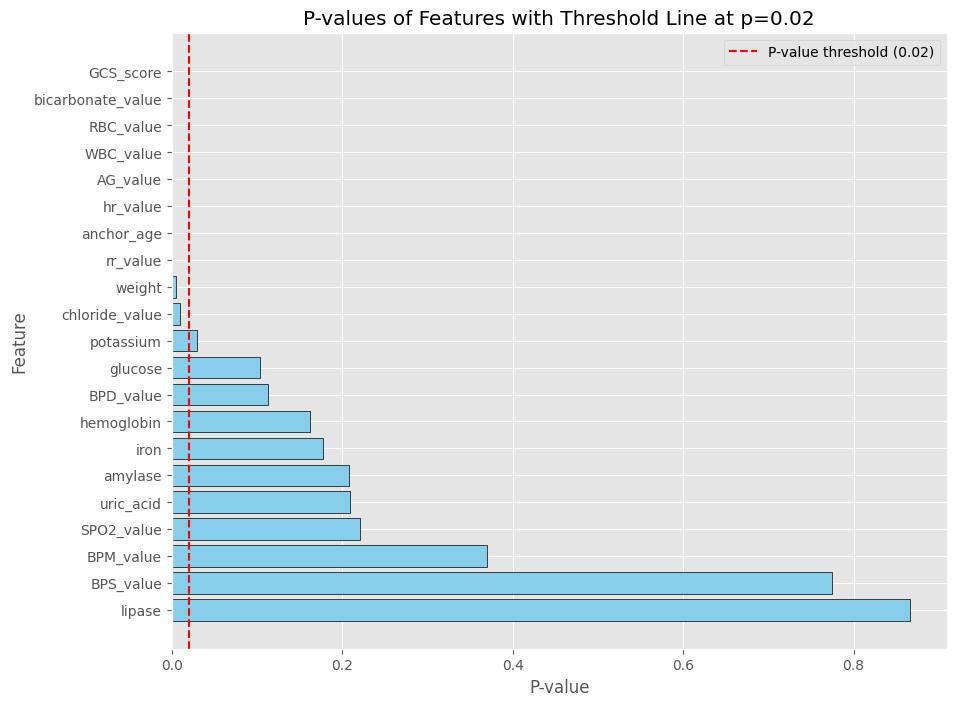

In [ ]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

# Create a mortality indicator
merged_df_corr = merged_df.copy()
merged_df_corr['death'] = merged_df_corr['deathtime'].notnull().astype(int)

# Exclude unnecessary columns
exclude_cols = ['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'death']
features = [col for col in merged_df_corr.columns if col not in exclude_cols]

# Initialize result lists
feature_names = []
correlations = []
p_values = []

# Calculate correlation and p-values for each feature
for feature in features:
    # Check if feature is numeric
    if pd.api.types.is_numeric_dtype(merged_df_corr[feature]):
        # Drop missing values for the calculation
        temp_df = merged_df_corr[[feature, 'death']].dropna()
        if len(temp_df) > 0:
            # Calculate the point-biserial correlation coefficient
            corr, p_val = stats.pointbiserialr(temp_df['death'], temp_df[feature])
            feature_names.append(feature)
            correlations.append(corr)
            p_values.append(p_val)

# Create results DataFrame
results_df = pd.DataFrame({
    'Feature': feature_names,
    'Correlation': correlations,
    'P-value': p_values
})

# Set p-value threshold
threshold = 0.02

# Sort results by p-value
results_df = results_df.sort_values(by='P-value')

# Visualization: vertical bar plot of p-values with threshold line
plt.figure(figsize=(10, 8))
plt.barh(results_df['Feature'], results_df['P-value'], color='skyblue', edgecolor='black')
plt.axvline(x=threshold, color='red', linestyle='--', label=f'P-value threshold ({threshold})')
plt.xlabel("P-value")
plt.ylabel("Feature")
plt.title("P-values of Features with Threshold Line at p=0.02")
plt.gca().invert_yaxis()  # Invert y-axis to have the lowest p-values at the top
plt.legend()
plt.show()


In [ ]:
results_df["Feature"]

,Feature
20,GCS_score
10,bicarbonate_value
11,RBC_value
12,WBC_value
8,AG_value
2,hr_value
0,anchor_age
3,rr_value
1,weight
9,chloride_value


In [ ]:
# drop uric_acid,hemoglobin,lipase,uric_acid,amylase,iron,hemoglobin,glucose,potassium
merged_df = merged_df.drop(columns=['uric_acid', 'hemoglobin', 'lipase', 'uric_acid', 'amylase', 'iron', 'hemoglobin', 'glucose', 'potassium'])

# Pre-processing

In [ ]:
na_columns = merged_df.isna().sum()
na_columns_with_na = na_columns[na_columns > 0]
print(na_columns_with_na)


deathtime            3455
marital_status        426
weight               1549
hr_value             1546
rr_value             1552
SPO2_value           3844
BPS_value            3327
BPD_value            3327
BPM_value            3324
AG_value             1684
chloride_value       1684
bicarbonate_value     138
RBC_value             144
WBC_value             144
GCS_score            1550
dtype: int64


## Convert Death time to 1 and 0

In [ ]:
merged_df.loc[merged_df['deathtime'].notna(),'dod'] = int(1)
merged_df.loc[merged_df['deathtime'].isnull(),'dod'] = int(0)
merged_df['dod'] = merged_df['dod'].astype(int)
merged_df.drop(columns=['deathtime'], inplace=True)
merged_df.shape

(3966, 23)

## Handle missing values

### Step 1: one hot encoding

In [ ]:
def create_check_test_columns(df, columns):

    for col in columns:
        # Create a new test column, True indicates the value is present, False indicates missing
        df[f'test_{col}'] = df[col].notna()
    return df

def fill_na_with_zero(df, columns):
  for col in columns:
        # Fill missing values with 0
        df[col] = df[col].fillna(0)
  return df

# List of columns to be processed
columns_to_handle = ['AG_value', 'chloride_value', 'bicarbonate_value', 'RBC_value', 'WBC_value',
                     'marital_status', 'weight', 'hr_value', 'rr_value', 'SPO2_value',
                     'BPS_value', 'BPD_value', 'BPM_value','GCS_score']

# Call the function to handle missing values
merged_df = create_check_test_columns(merged_df, columns_to_handle)
merged_df

,subject_id,hadm_id,admittime,dischtime,insurance,marital_status,race,gender,anchor_age,weight,...,test_WBC_value,test_marital_status,test_weight,test_hr_value,test_rr_value,test_SPO2_value,test_BPS_value,test_BPD_value,test_BPM_value,test_GCS_score
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,...,True,True,True,True,True,False,False,False,False,True
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,Medicare,None,UNKNOWN,M,87,81.0,...,True,False,True,True,True,False,True,True,True,True
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,...,True,True,True,True,True,False,False,False,False,True
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,Medicare,MARRIED,WHITE,M,79,NaN,...,True,True,False,False,False,False,False,False,False,False
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,...,True,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,...,True,True,True,True,True,False,False,False,False,True
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,...,True,True,False,False,False,False,False,False,False,False
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,...,True,True,False,False,False,False,False,False,False,False
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,Other,SINGLE,WHITE,F,62,92.0,...,True,True,True,True,True,False,False,False,False,True


### step2: fill Nan with zero

In [ ]:
merged_df = fill_na_with_zero(merged_df, columns_to_handle)
merged_df

,subject_id,hadm_id,admittime,dischtime,insurance,marital_status,race,gender,anchor_age,weight,...,test_WBC_value,test_marital_status,test_weight,test_hr_value,test_rr_value,test_SPO2_value,test_BPS_value,test_BPD_value,test_BPM_value,test_GCS_score
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,...,True,True,True,True,True,False,False,False,False,True
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,Medicare,0,UNKNOWN,M,87,81.0,...,True,False,True,True,True,False,True,True,True,True
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,...,True,True,True,True,True,False,False,False,False,True
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,Medicare,MARRIED,WHITE,M,79,0.0,...,True,True,False,False,False,False,False,False,False,False
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,0.0,...,True,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,...,True,True,True,True,True,False,False,False,False,True
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,0.0,...,True,True,False,False,False,False,False,False,False,False
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,0.0,...,True,True,False,False,False,False,False,False,False,False
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,Other,SINGLE,WHITE,F,62,92.0,...,True,True,True,True,True,False,False,False,False,True


## One hot encoding

In [ ]:
# insurance, martial_Status
merged_df = pd.get_dummies(merged_df, columns=['insurance', 'marital_status'], drop_first=True)
merged_df

,subject_id,hadm_id,admittime,dischtime,race,gender,anchor_age,weight,hr_value,rr_value,...,test_BPS_value,test_BPD_value,test_BPM_value,test_GCS_score,insurance_Medicare,insurance_Other,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_WIDOWED
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,WHITE,M,74,131.0,69.052632,16.025000,...,False,False,False,True,True,False,False,False,True,False
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,UNKNOWN,M,87,81.0,127.480000,26.714286,...,True,True,True,True,True,False,False,False,False,False
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,BLACK/AFRICAN AMERICAN,M,40,95.4,85.208333,15.458333,...,False,False,False,True,False,True,False,False,True,False
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,WHITE,M,79,0.0,0.000000,0.000000,...,False,False,False,False,True,False,False,True,False,False
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,BLACK/CARIBBEAN ISLAND,M,52,0.0,0.000000,0.000000,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,ASIAN - CHINESE,F,50,75.6,80.800000,18.320000,...,False,False,False,True,False,True,False,True,False,False
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,HISPANIC/LATINO - DOMINICAN,F,76,0.0,0.000000,0.000000,...,False,False,False,False,True,False,False,False,False,True
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,PATIENT DECLINED TO ANSWER,M,48,0.0,0.000000,0.000000,...,False,False,False,False,False,True,False,False,True,False
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,WHITE,F,62,92.0,63.097826,19.315217,...,False,False,False,True,False,True,False,False,True,False


## Change Gender to numeric

In [ ]:
merged_df['gender'] = merged_df['gender'].astype(str)
gender_mapping = {'F': 0, 'M': 1}
merged_df['gender'] = merged_df['gender'].map(gender_mapping)
merged_df

,subject_id,hadm_id,admittime,dischtime,race,gender,anchor_age,weight,hr_value,rr_value,...,test_BPS_value,test_BPD_value,test_BPM_value,test_GCS_score,insurance_Medicare,insurance_Other,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_WIDOWED
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,WHITE,1,74,131.0,69.052632,16.025000,...,False,False,False,True,True,False,False,False,True,False
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,UNKNOWN,1,87,81.0,127.480000,26.714286,...,True,True,True,True,True,False,False,False,False,False
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,BLACK/AFRICAN AMERICAN,1,40,95.4,85.208333,15.458333,...,False,False,False,True,False,True,False,False,True,False
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,WHITE,1,79,0.0,0.000000,0.000000,...,False,False,False,False,True,False,False,True,False,False
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,BLACK/CARIBBEAN ISLAND,1,52,0.0,0.000000,0.000000,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,ASIAN - CHINESE,0,50,75.6,80.800000,18.320000,...,False,False,False,True,False,True,False,True,False,False
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,HISPANIC/LATINO - DOMINICAN,0,76,0.0,0.000000,0.000000,...,False,False,False,False,True,False,False,False,False,True
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,PATIENT DECLINED TO ANSWER,1,48,0.0,0.000000,0.000000,...,False,False,False,False,False,True,False,False,True,False
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,WHITE,0,62,92.0,63.097826,19.315217,...,False,False,False,True,False,True,False,False,True,False


## Remove Subject and hadm id

In [ ]:
merged_df = merged_df.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime'])
merged_df

,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value,...,test_BPS_value,test_BPD_value,test_BPM_value,test_GCS_score,insurance_Medicare,insurance_Other,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_WIDOWED
0,WHITE,1,74,131.0,69.052632,16.025000,0.0,0.0,0.0,0.0,...,False,False,False,True,True,False,False,False,True,False
1,UNKNOWN,1,87,81.0,127.480000,26.714286,0.0,105.0,54.5,69.0,...,True,True,True,True,True,False,False,False,False,False
2,BLACK/AFRICAN AMERICAN,1,40,95.4,85.208333,15.458333,0.0,0.0,0.0,0.0,...,False,False,False,True,False,True,False,False,True,False
3,WHITE,1,79,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,True,False,False
4,BLACK/CARIBBEAN ISLAND,1,52,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,ASIAN - CHINESE,0,50,75.6,80.800000,18.320000,0.0,0.0,0.0,0.0,...,False,False,False,True,False,True,False,True,False,False
3962,HISPANIC/LATINO - DOMINICAN,0,76,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,True
3963,PATIENT DECLINED TO ANSWER,1,48,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,True,False
3964,WHITE,0,62,92.0,63.097826,19.315217,0.0,0.0,0.0,0.0,...,False,False,False,True,False,True,False,False,True,False


# Logistic Regression


In [ ]:
merged_df.columns

Index(['race', 'gender', 'anchor_age', 'weight', 'hr_value', 'rr_value',
       'SPO2_value', 'BPS_value', 'BPD_value', 'BPM_value', 'AG_value',
       'chloride_value', 'bicarbonate_value', 'RBC_value', 'WBC_value',
       'GCS_score', 'dod', 'test_AG_value', 'test_chloride_value',
       'test_bicarbonate_value', 'test_RBC_value', 'test_WBC_value',
       'test_marital_status', 'test_weight', 'test_hr_value', 'test_rr_value',
       'test_SPO2_value', 'test_BPS_value', 'test_BPD_value', 'test_BPM_value',
       'test_GCS_score', 'insurance_Medicare', 'insurance_Other',
       'marital_status_DIVORCED', 'marital_status_MARRIED',
       'marital_status_SINGLE', 'marital_status_WIDOWED'],
      dtype='object')

Outer cross-validation scores: [0.82384824 0.81391147 0.82746161 0.83197832 0.82459313]
Mean outer score: 0.82435855341073
              precision    recall  f1-score   support

           0       0.96      0.84      0.90       688
           1       0.43      0.80      0.56       106

    accuracy                           0.83       794
   macro avg       0.70      0.82      0.73       794
weighted avg       0.89      0.83      0.85       794



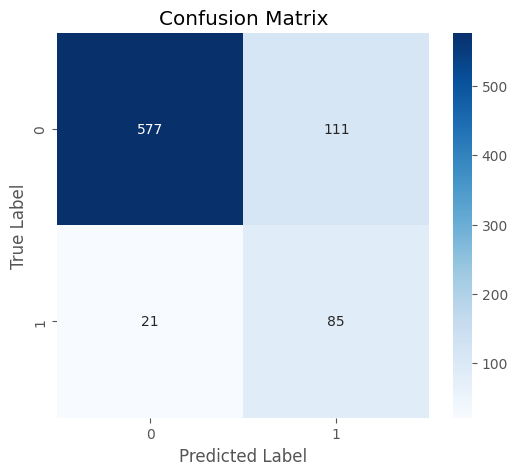

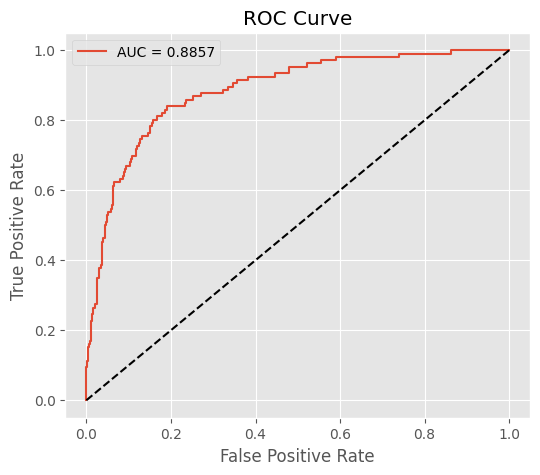

In [ ]:
# Select features and target variable
X = merged_df.drop(columns=['dod'])  # Drop the 'dod' column to get the features
y = merged_df['dod']  # Extract the 'dod' column as the target

# Apply target encoding to the 'race' column
target_encoder = ce.TargetEncoder(cols=['race'])
X = target_encoder.fit_transform(X, y)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply random oversampling to balance the dataset
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Define the Logistic Regression model (without Lasso)
log_reg = LogisticRegression(solver='liblinear', max_iter=1000)

# Define grid search parameters (C parameter for regularization)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]  # C is the inverse of the regularization strength
}

# Apply GridSearchCV for hyperparameter tuning within nested 5-fold cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')

# Perform outer 5-fold cross-validation
outer_scores = cross_val_score(grid_search, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')

# Print outer cross-validation scores
print("Outer cross-validation scores:", outer_scores)
print("Mean outer score:", np.mean(outer_scores))

# Fit the final model on the training set
grid_search.fit(X_train_resampled, y_train_resampled)

mean_test_scores = grid_search.cv_results_['mean_test_score']
param_values = [param['C'] for param in grid_search.cv_results_['params']]

# Predict on the test set
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot the ROC curve
y_proba = grid_search.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# LASSO Model

In [ ]:
# Select features and target variable
X = merged_df.drop(columns=['dod'])  # Drop the 'dod' column to get the features
y = merged_df['dod']  # Extract the 'dod' column as the target

# Apply target encoding to the 'race' column
target_encoder = ce.TargetEncoder(cols=['race'])
X = target_encoder.fit_transform(X, y)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply random oversampling to balance the dataset
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Define the Lasso Logistic Regression model and parameter range
lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Define grid search parameters
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]  # C is the inverse of the regularization strength
}

# Apply GridSearchCV for hyperparameter tuning within nested 5-fold cross-validation
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='accuracy')


# Perform outer 5-fold cross-validation
outer_scores = cross_val_score(grid_search, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')

# Print outer cross-validation scores
print("Outer cross-validation scores:", outer_scores)
print("Mean outer score:", np.mean(outer_scores))

# Fit the final model on the training set
grid_search.fit(X_train_resampled, y_train_resampled)

mean_test_scores = grid_search.cv_results_['mean_test_score']
param_values = [param['C'] for param in grid_search.cv_results_['params']]




Outer cross-validation scores: [0.82836495 0.81300813 0.82836495 0.83107498 0.82459313]
Mean outer score: 0.8250812273041357



Lasso Logistic Regression Model Evaluation Metrics:
Accuracy: 0.8337531486146096
Precision: 0.4336734693877551
Recall: 0.8018867924528302
ROC AUC Score: 0.8856132075471698
              precision    recall  f1-score   support

           0       0.96      0.84      0.90       688
           1       0.43      0.80      0.56       106

    accuracy                           0.83       794
   macro avg       0.70      0.82      0.73       794
weighted avg       0.89      0.83      0.85       794



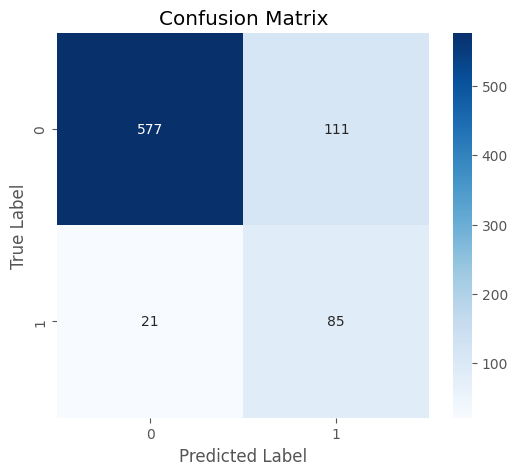

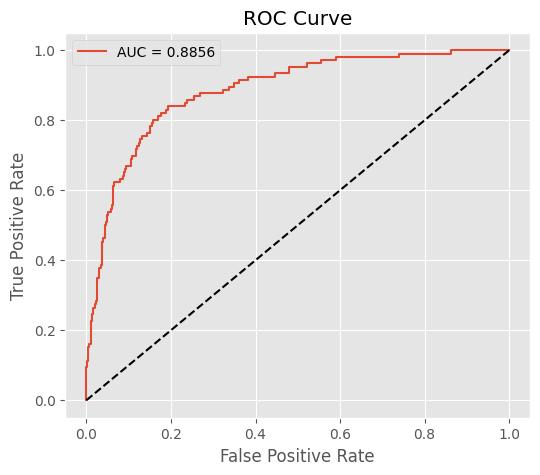

In [ ]:
# Predict on the test set
y_pred = grid_search.predict(X_test)
# Classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nLasso Logistic Regression Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("ROC AUC Score:", roc_auc)

# Print the classification report
print(classification_report(y_test, y_pred))


# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot the ROC curve
y_proba = grid_search.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

##################### 随机森林 Random Forest #####################
# Select features and target variable
X = merged_df.drop(columns=['dod'])  # Drop the 'dod' column to get the features
y = merged_df['dod']  # Extract the 'dod' column as the target

# Apply target encoding to the 'race' column
target_encoder = ce.TargetEncoder(cols=['race'])
X = target_encoder.fit_transform(X, y)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply random oversampling to balance the dataset
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Define the Random Forest model and parameter range
rf = RandomForestClassifier(random_state=42)

# Define grid search parameters
param_grid = {
    'n_estimators': [50, 100, 200],   # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10]   # Minimum number of samples required to split an internal node
}

# Apply GridSearchCV for hyperparameter tuning within nested 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')

# Perform outer 5-fold cross-validation
outer_scores = cross_val_score(grid_search, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')

# Print outer cross-validation scores
print("Outer cross-validation scores:", outer_scores)
print("Mean outer score:", np.mean(outer_scores))

# Fit the final model on the training set
grid_search.fit(X_train_resampled, y_train_resampled)

# Mean test scores for each parameter combination
mean_test_scores = grid_search.cv_results_['mean_test_score']
param_values = [param for param in grid_search.cv_results_['params']]

# Predict on the test set
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Feature importance (identify important features using Random Forest)
rf_best_model = grid_search.best_estimator_
important_features = np.array(X.columns)[rf_best_model.feature_importances_ > 0]
print("Important features selected by Random Forest:", important_features)

Outer cross-validation scores: [0.96838302 0.9701897  0.97380307 0.97741644 0.97377939]
Mean outer score: 0.9727143232854871
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       688
           1       0.73      0.44      0.55       106

    accuracy                           0.90       794
   macro avg       0.83      0.71      0.75       794
weighted avg       0.89      0.90      0.89       794

Important features selected by Random Forest: ['race' 'gender' 'anchor_age' 'weight' 'hr_value' 'rr_value' 'SPO2_value'
 'BPS_value' 'BPD_value' 'BPM_value' 'AG_value' 'chloride_value'
 'bicarbonate_value' 'RBC_value' 'WBC_value' 'GCS_score' 'test_AG_value'
 'test_chloride_value' 'test_bicarbonate_value' 'test_RBC_value'
 'test_WBC_value' 'test_marital_status' 'test_weight' 'test_hr_value'
 'test_rr_value' 'test_SPO2_value' 'test_BPS_value' 'test_BPD_value'
 'test_BPM_value' 'test_GCS_score' 'insurance_Medicare' 'insurance_Other'
 'marital_st


Lasso Logistic Regression Model Evaluation Metrics:
Accuracy: 0.9042821158690176
Precision: 0.734375
Recall: 0.44339622641509435
ROC AUC Score: 0.8839814611671786
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       688
           1       0.73      0.44      0.55       106

    accuracy                           0.90       794
   macro avg       0.83      0.71      0.75       794
weighted avg       0.89      0.90      0.89       794



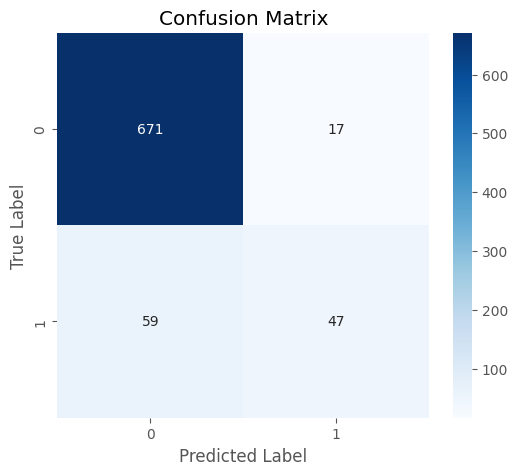

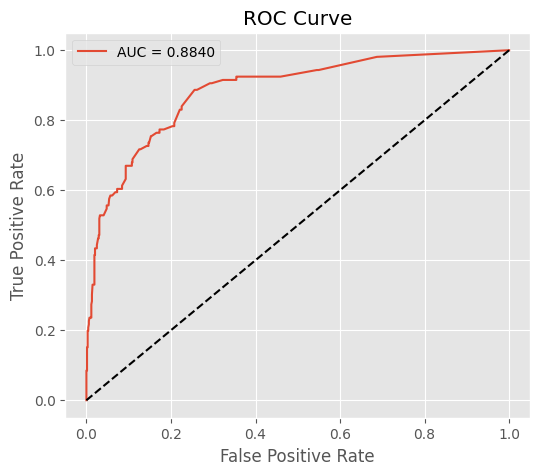

In [ ]:
# Predict on the test set
y_pred = grid_search.predict(X_test)
# Classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nLasso Logistic Regression Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("ROC AUC Score:", roc_auc)

# Print the classification report
print(classification_report(y_test, y_pred))


# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot the ROC curve
y_proba = grid_search.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()